# TensorFlow Lite for Edge Deployment

So far, we’ve trained models and generated in-memory predictions. In many real-world applications, we want models to **run efficiently on edge devices**:

- Mobile phones  
- Raspberry Pi or IoT devices  
- Cameras or other embedded hardware  

TensorFlow Lite (TFLite) is a lightweight framework that converts TensorFlow models to a **smaller, optimized format** for fast, low-resource inference.  

In this notebook, you will learn how to:

1. Load a trained model (or train a lightweight model locally).  
2. Convert the model to TensorFlow Lite format.  
3. Perform inference on a single image using the TFLite interpreter.  
4. Compare predictions to the original model.  

By the end of this notebook, you will understand how to **deploy computer vision models to edge devices** in a CPU-friendly way, entirely locally in JupyterLab.


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os

# Load or Train Model

IMG_SIZE = 224
MODEL_PATH = "saved_model/flowers_model" #Update path to your saved model (or leave as-is to generate a new one)
# Example: MODEL_PATH = "..\\07_training\\model_registry\\v_20260215_185521\\" 
# --> ".." traverses one parent directory
# --> The double backslashes are needed on Windows (the first backslash protects the second from Python interpretation)

if os.path.exists(MODEL_PATH):
    model = tf.keras.models.load_model(MODEL_PATH)
    print("Loaded saved model.")
    IMG_SIZE = model.input_shape[1]
    print(f"Model expects: {model.input_shape}")
else:
    print("Saved model not found. Training lightweight model for demo...")
    (ds_train, ds_val), ds_info = tfds.load(
        "tf_flowers",
        split=["train[:80%]", "train[80%:]"],
        as_supervised=True,
        with_info=True
    )
    NUM_CLASSES = ds_info.features["label"].num_classes

    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    def preprocess(image, label):
        image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
        image = image / 255.0
        return image, label
    
    ds_train = ds_train.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
    model.fit(ds_train, epochs=1)
    
    # Save for reuse
    os.makedirs("saved_model", exist_ok=True)
    model.save(MODEL_PATH)



Loaded saved model.
Model expects: (None, 128, 128, 3)


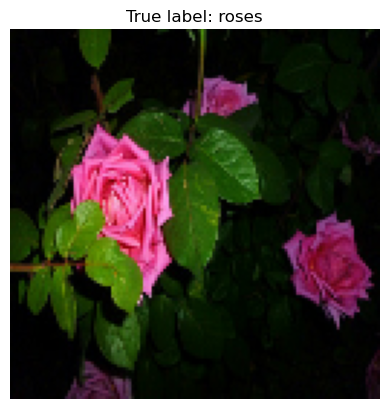

In [2]:
# Load a Sample Image

# Use first image from validation set for demo
(ds_train, ds_val), ds_info = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)

CLASS_NAMES = ds_info.features["label"].names

def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

ds_val = ds_val.map(preprocess_image).batch(1)

for image, label in ds_val.take(1):
    sample_image = image.numpy()[0]
    sample_label = label.numpy()[0]
    plt.imshow(sample_image)
    plt.title(f"True label: {CLASS_NAMES[sample_label]}")
    plt.axis("off")
    plt.show()
    break


In [3]:
# Convert to TFLite

TFLITE_MODEL_PATH = "flowers_model.tflite"

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save TFLite model
with open(TFLITE_MODEL_PATH, "wb") as f:
    f.write(tflite_model)

print(f"TFLite model saved to {TFLITE_MODEL_PATH}")


INFO:tensorflow:Assets written to: C:\Users\JASONE~1\AppData\Local\Temp\tmpfidtl_o3\assets


INFO:tensorflow:Assets written to: C:\Users\JASONE~1\AppData\Local\Temp\tmpfidtl_o3\assets


TFLite model saved to flowers_model.tflite


In [4]:
# Load TFLite Model and Run Inference

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)
interpreter.allocate_tensors()

# Get input/output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Preprocess sample image
input_data = np.expand_dims(sample_image.astype(np.float32), axis=0)

# Run inference
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
tflite_pred = interpreter.get_tensor(output_details[0]['index'])
tflite_label = np.argmax(tflite_pred, axis=1)[0]

print(f"TFLite Prediction: {CLASS_NAMES[tflite_label]}")


TFLite Prediction: roses


In [5]:
# Compare to Original Model

orig_pred = np.argmax(model.predict(np.expand_dims(sample_image, axis=0)), axis=1)[0]
print(f"Original Model Prediction: {CLASS_NAMES[orig_pred]}")

if orig_pred == tflite_label:
    print("✅ Predictions match between original and TFLite model.")
else:
    print("⚠ Predictions differ! This can happen for very small differences.")


1/1 [==============================] - 0s 106ms/step
Original Model Prediction: roses
✅ Predictions match between original and TFLite model.


## Notes
- TFLite converts the model into a smaller, edge-friendly format while preserving accuracy.
- Inference uses the TFLite interpreter, which simulates deployment on mobile/embedded devices.
- You can extend this to batch inference, camera input, or microcontroller deployment later.